In [1]:
import os
import cv2
import plotly.graph_objects as go

from utilities.ArUco_detector import visualize_detections_on_image, get_marker_positions, add_cameras_to_fig, add_markers_to_fig, extract_2d_marker_positions, add_skeleton_to_fig
from utilities.camera import load_cameras_from_json


In [2]:
calibration_file = 'calibration_dome.json'  # the calibrated camera params
input_base_path = "/data/vci/motion_markers"
sequence_name = "2026_01_29_motion_markers_001"
frame_range = 183

In [3]:
uppermost_view_names = ["C0025", "C0030", "C0024", "C0019", "C0031", "C0039"]
middle_view_names = ["C0007", "C0004", "C0006", "C0026", "C0028", "C0012",]
view_names = uppermost_view_names + middle_view_names

my_cameras = load_cameras_from_json(calibration_file, view_names)
scale = 1.0
for cam in my_cameras:
    cam.adjust_intrinsic_for_scale(scale)

In [4]:
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
aruco_params = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(aruco_dict, aruco_params)
detections = [[] for _ in range(len(view_names))]

frame_idx = 0
inputs = []
for i, view_name in enumerate(view_names):
    image_path = os.path.join(input_base_path,sequence_name,f"frame_{(frame_idx*2):05d}","rgb",f"{view_name}.png") # Load every two frames, 15 FPS is enough tp preview
    img_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    corners, ids, rejected = detector.detectMarkers(img_bgr)
    inputs.append(img_rgb)
    
    # Store in the structure expected by your functions
    detections[i].append({
        "ids": ids,
        "corners": corners
    })

Found 9 markers. Visualizing detections.


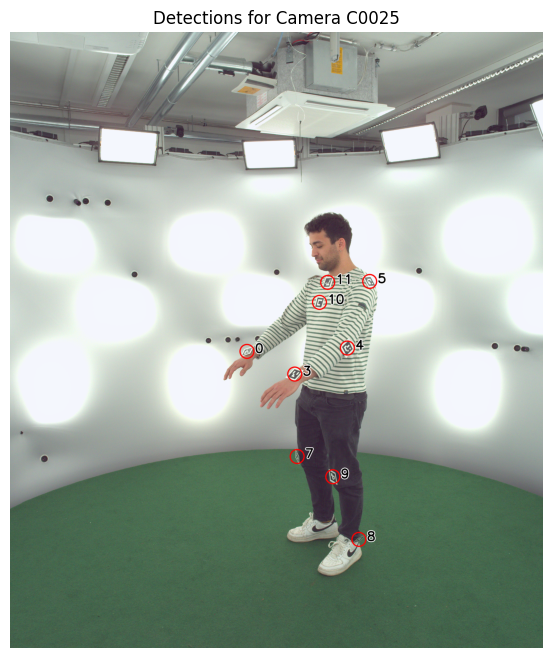

[{'id': 9, 'center': (2790.75, 3846.25)},
 {'id': 4, 'center': (2916.75, 2733.0)},
 {'id': 3, 'center': (2461.0, 2958.5)},
 {'id': 5, 'center': (3109.25, 2157.25)},
 {'id': 10, 'center': (2675.25, 2338.75)},
 {'id': 11, 'center': (2746.25, 2165.75)},
 {'id': 0, 'center': (2048.75, 2762.75)},
 {'id': 8, 'center': (3016.75, 4388.75)},
 {'id': 7, 'center': (2482.5, 3671.5)}]

In [5]:
camera_id = 11

visualize_detections_on_image(
    inputs[camera_id], 
    detections[camera_id][0], 
    title=f"Detections for Camera C0025"
)

extract_2d_marker_positions(detections[camera_id][0])

In [6]:
marker_positions = get_marker_positions(
    detections=detections,
    cameras=my_cameras,
    input_is_undistorted=True
)

marker_positions

{0: {0: array([-0.01254789, -1.12629861, -0.28545   ]),
  1: array([-0.24575857, -1.23645779, -0.34570726]),
  2: array([-0.38433685, -1.49746334, -0.1740068 ]),
  3: array([ 0.07255755, -1.09234421,  0.22561755]),
  4: array([-0.15196393, -1.19362763,  0.31670631]),
  5: array([-0.34698736, -1.48097714,  0.26028061]),
  6: array([-0.48775855, -0.14753923, -0.22223056]),
  7: array([-0.25605623, -0.53657192, -0.1882786 ]),
  9: array([-0.26127392, -0.50905283,  0.09434812]),
  10: array([-0.25579591, -1.37905253,  0.00829199]),
  11: array([-0.30025375, -1.47645098,  0.01983087])}}

In [8]:
fig = go.Figure()
fig = add_cameras_to_fig(fig, my_cameras, scale=0.2)
fig = add_markers_to_fig(fig, marker_positions)
fig = add_skeleton_to_fig(fig, marker_positions, [(0,1),(1,2),(2,11),(3,4),(4,5),(5,11),(6,7),(8,9),(10,11)])
fig.update_layout(
    title="VCI ArUco 3D Locations",
    scene=dict(
        xaxis_title='X (meters)',
        yaxis_title='Y (meters)',
        zaxis_title='Z (meters)',
        aspectmode='data',
        camera=dict(
            up=dict(x=0, y=-1, z=0),   # Sets the Z-axis to point 'up'
            eye=dict(x=1.5, y=1.5, z=1.5) # Initial camera position
        )
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)
fig.show()